In [55]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
from sklearn.preprocessing import minmax_scale
from typing import Tuple, Optional, Any, Dict, List


class HyperspectralProcessor:
    """
    Robust hyperspectral image processing with support for multiple datasets.
    Consolidates all preprocessing functionality into a clean, reusable class.
    """
    
    DATASET_CONFIG = {
        0: {  # Cuprite
            'name': 'Cuprite',
            'data_file': 'cuprite/cupriteS1_R188.mat',
            'gt_file': 'cuprite/groundTruth_Cuprite_nEnd12.mat',
            'meta_file': 'cuprite/cuprite.mat',
            'dimensions': (190, 250, 188),  # (w, h, bands)
            'data_vars': ['Y'],
            'gt_vars': ['M'],
            'saturation_threshold': 60000,
            'rgb_bands': [28, 18, 8],  # 0-based indices for RGB visualization
            'endmembers': 12,
            'use_slctBnds': True,  # Use selected bands from cuprite.mat
        },
        1: {  # PaviaU
            'name': 'PaviaU', 
            'data_file': 'pavia/PaviaU.mat',
            'gt_file': 'pavia/PaviaU_gt.mat',
            'meta_file': 'pavia/pavia.mat',
            'data_vars': ['paviaU'],
            'gt_vars': ['paviaU_gt'],
            'bands': 103,
            'endmembers': 7,
            'class_mapping': {1: [1, 7], 2: [2], 3: [4], 4: [5], 5: [6], 6: [3, 8], 7: [9]},
        },
        2: {  # Gulfport
            'name': 'Gulfport',
            'data_file': 'gulfport/muufl_gulfport_campus_1_hsi_220_label.mat',
            'meta_file': 'gulfport/gulfport.mat',
            'data_vars': ['hsi'],
            'bands': 64,
            'endmembers': 7,
            'class_mapping': {1: [1], 2: [2], 3: [3], 4: [4], 5: [5], 6: [7], 7: [8]},
        },
        3: {  # Jasper Ridge
            'name': 'Jasper Ridge',
            'data_file': 'jasper/jasperRidge2_R198.mat',
            'gt_file': 'jasper/end4.mat',
            'meta_file': 'jasper/jasper.mat',
            'dimensions': (100, 100, 198),  # (w, h, bands)
            'data_vars': ['Y'],
            'gt_vars': ['M'],
            'saturation_threshold': 60000,
            'endmembers': 4,
        },
        4: {  # Urban
            'name': 'Urban',
            'data_file': 'urban/Urban_R162.mat',
            'gt_file': 'urban/end4_groundTruth.mat',
            'meta_file': 'urban/urban.mat',
            'dimensions': (307, 307, 162),  # (w, h, bands)
            'data_vars': ['Y'],
            'gt_vars': ['M'],
            'saturation_threshold': 60000,
            'endmembers': 4,
        },
        5: {  # Samson
            'name': 'Samson',
            'data_file': 'samson/samson.mat',
            'gt_file': 'samson/end3.mat',
            'meta_file': 'samson/samson.mat',
            'dimensions': (95, 95, 156),  # (w, h, bands)
            'data_vars': ['W1'],
            'gt_vars': ['M'],
            'endmembers': 3,
            'no_normalize': True,  # Samson doesn't use hyperNormalize in MATLAB
        }
    }


    def __init__(self, base_path: str = ".", verbose: bool = True):
        """
        Initialize processor with base path to datasets.
        
        Args:
            base_path: Root directory containing dataset folders
            verbose: Whether to print processing information
        """
        self.base_path = base_path
        self.verbose = verbose

    def _loadmat_safe(self, path: str) -> Dict[str, Any]:
        """Safely load MATLAB file with optional verbose output."""
        if self.verbose:
            print(f"Loading: {path}")
        return sio.loadmat(path)

    def _squeeze_mat(self, var: Any) -> np.ndarray:
        """
        Recursively unwrap MATLAB-loaded objects to numeric ndarray.
        Handles nested structs, object arrays, and field extraction.
        """
        if isinstance(var, np.ndarray):
            # Structured array with fields
            if getattr(var, "dtype", None) is not None and var.dtype.names:
                field = var.dtype.names[0]
                return self._squeeze_mat(var[field][0, 0])
            
            # Object arrays (nested structs)
            if var.dtype == object:
                try:
                    return self._squeeze_mat(var[0, 0])
                except Exception:
                    # Try first numeric-looking entry
                    for item in var.flat:
                        try:
                            return self._squeeze_mat(item)
                        except Exception:
                            continue
                    raise ValueError("Could not unpack object-array from loadmat.")
            
            # Numeric ndarray
            return np.asarray(var).squeeze()
        else:
            # Scalar or python types
            return np.asarray(var)

    def _get_variable(self, mat: Dict[str, Any], candidates: List[str]) -> Optional[np.ndarray]:
        """
        Look up first matching variable name and return numeric ndarray.
        
        Args:
            mat: Loaded MATLAB data dictionary
            candidates: List of possible variable names to try
            
        Returns:
            Squeezed numeric array or None if not found
        """
        for name in candidates:
            if name in mat:
                if self.verbose:
                    print(f"Found variable '{name}' in .mat file")
                return self._squeeze_mat(mat[name])
        
        if self.verbose:
            available_keys = [k for k in mat.keys() if not k.startswith('__')]
            print(f"None of {candidates} found. Available keys: {available_keys}")
        return None

    def normalize_global(self, data: np.ndarray) -> np.ndarray:
        """Normalize entire dataset to [0,1] range globally."""
        data = data.astype(float)
        min_val, max_val = data.min(), data.max()
        if max_val == min_val:
            return np.zeros_like(data, dtype=float)
        return (data - min_val) / (max_val - min_val)

    def normalize_per_band(self, img: np.ndarray) -> np.ndarray:
        """Normalize each spectral band independently to [0,1]."""
        if img.ndim != 3:
            raise ValueError("Input must be 3D array (h, w, bands)")
        
        img = img.astype(float)
        for band in range(img.shape[2]):
            band_data = img[:, :, band]
            min_val, max_val = band_data.min(), band_data.max()
            if max_val > min_val:  # Avoid divide by zero
                img[:, :, band] = (band_data - min_val) / (max_val - min_val)
        return img

    def convert_to_2d(self, img: np.ndarray) -> np.ndarray:
        """
        Convert hyperspectral cube to 2D matrix.
        
        Args:
            img: Input array (h, w, bands) or (h, w) for single band
            
        Returns:
            2D array of shape (bands, pixels)
        """
        if img.ndim < 2 or img.ndim > 3:
            raise ValueError("Input must be 2D or 3D array")
        
        if img.ndim == 2:
            h, w = img.shape
            return img.reshape((h * w, 1)).T
        else:
            h, w, bands = img.shape
            return img.reshape((h * w, bands)).T

    def _process_cuprite_endmembers(self, gt_data: Dict[str, Any], num_bands: int) -> np.ndarray:
        """Process Cuprite ground truth endmembers."""
        config = self.DATASET_CONFIG[0]
        M = self._get_variable(gt_data, config['gt_vars'])
        
        if M is None:
            available_keys = [k for k in gt_data.keys() if not k.startswith('__')]
            raise KeyError(f"Could not find endmember matrix. Available keys: {available_keys}")

        Mp = np.asarray(M)
        
        # Handle orientation automatically
        if Mp.ndim == 2:
            if Mp.shape[0] == num_bands and Mp.shape[1] != num_bands:
                # Already (bands, endmembers)
                pass
            elif Mp.shape[1] == num_bands and Mp.shape[0] != num_bands:
                # Transpose to (bands, endmembers)
                Mp = Mp.T
            else:
                # Ambiguous - try to match num_bands
                if Mp.shape[0] == num_bands:
                    pass
                elif Mp.shape[1] == num_bands:
                    Mp = Mp.T
                else:
                    if self.verbose:
                        print(f"Warning: Endmember shape {Mp.shape} doesn't match "
                              f"expected bands {num_bands}")
        
        return Mp

    def _process_pavia_endmembers(self, img_2d: np.ndarray, labels: np.ndarray, num_bands: int) -> np.ndarray:
        """Process PaviaU endmembers by averaging class pixels."""
        config = self.DATASET_CONFIG[1]
        H = config['endmember_classes']
        
        # Transpose to (pixels, bands) for easier indexing
        x = img_2d.T
        
        # Build endmember matrix exactly like original MATLAB code
        Mp = np.zeros((H, num_bands))
        Mp[0, :] = np.mean(x[(labels == 1) | (labels == 7)], axis=0)
        Mp[1, :] = np.mean(x[labels == 2], axis=0)
        Mp[2, :] = np.mean(x[labels == 4], axis=0)
        Mp[3, :] = np.mean(x[labels == 5], axis=0)
        Mp[4, :] = np.mean(x[labels == 6], axis=0)
        Mp[5, :] = np.mean(x[(labels == 3) | (labels == 8)], axis=0)
        Mp[6, :] = np.mean(x[labels == 9], axis=0)
        
        return Mp.T  # Return as (bands, endmembers)

    def preprocess_dataset(self, dataset_id: int) -> Tuple[np.ndarray, np.ndarray, Optional[int], Optional[int], int, int]:
        if dataset_id not in self.DATASET_CONFIG:
            raise ValueError(f"Dataset ID {dataset_id} not supported.")

        config = self.DATASET_CONFIG[dataset_id]
        if self.verbose:
            print(f"\n--- Processing {config['name']} Dataset ---")

        data = self._loadmat_safe(f"{self.base_path}/{config['data_file']}")

        if dataset_id == 0:
            return self._process_cuprite(data, config)
        elif dataset_id == 1:
            return self._process_pavia(data, config)
        elif dataset_id == 2:
            return self._process_gulfport(data, config)
        elif dataset_id == 3:
            return self._process_jasper(data, config)
        elif dataset_id == 4:
            return self._process_urban(data, config)
        elif dataset_id == 5:
            return self._process_samson(data, config)
        else:
            raise NotImplementedError(f"Dataset {dataset_id} processing not yet implemented")

    def _process_cuprite(self, data: Dict[str, Any], config: Dict) -> Tuple:
        """Process Cuprite dataset specifically."""
        # Load ground truth
        gt_path = f"{self.base_path}/{config['gt_file']}"
        gt_data = self._loadmat_safe(gt_path)
        
        # Get hyperspectral data
        x = self._get_variable(data, config['data_vars'])
        if x is None:
            available_keys = [k for k in data.keys() if not k.startswith('__')]
            raise KeyError(f"Could not find hyperspectral data. Available keys: {available_keys}")

        # Clean saturated values  
        x = np.array(x, dtype=float)
        x[x > config['saturation_threshold']] = 0.0

        # Get dimensions - CORRECTED: h, w, not w, h
        w, h, num_bands = config['dimensions']  # w=250, h=190, bands=188

        # Reshape to 3D cube - CORRECTED to match your working version
        if x.ndim == 2:
            # img2d: (bands, pixels) → (pixels, bands) → (h, w, bands)
            # This matches your working code exactly
            img_cube = x.T.reshape(h, w, num_bands)  # (190, 250, 188)
        elif x.ndim == 3:
            img_cube = x
        else:
            raise ValueError(f"Unexpected shape for hyperspectral data: {x.shape}")

        # Normalize and convert to 2D  
        img_normalized = self.normalize_per_band(img_cube)
        img2d = self.convert_to_2d(img_normalized)

        # Process endmembers
        Mp = self._process_cuprite_endmembers(gt_data, num_bands)
        num_endmembers = Mp.shape[1] if Mp.ndim == 2 else 1

        return img2d, Mp, w, h, num_bands, num_endmembers

    def _process_pavia(self, data: Dict[str, Any], config: Dict) -> Tuple:
        """Process PaviaU dataset specifically."""
        # Load ground truth
        gt_path = f"{self.base_path}/{config['gt_file']}"
        gt_data = self._loadmat_safe(gt_path)
        
        # Get hyperspectral data
        pavia_cube = self._get_variable(data, config['data_vars'])
        if pavia_cube is None:
            available_keys = [k for k in data.keys() if not k.startswith('__')]
            raise KeyError(f"Could not find PaviaU data. Available keys: {available_keys}")

        w, h, num_bands = pavia_cube.shape
        
        # Normalize and flatten
        img_normalized = self.normalize_per_band(pavia_cube)
        img2d = self.convert_to_2d(img_normalized)
        
        # Get ground truth labels
        labels = self._get_variable(gt_data, config['gt_vars'])
        if labels is None:
            raise KeyError("Could not find ground truth labels")
        labels = labels.reshape((w * h,))

        # Process endmembers
        Mp = self._process_pavia_endmembers(img2d, labels, num_bands)
        num_endmembers = config['endmember_classes']

        return img2d, Mp, w, h, num_bands, num_endmembers
    
    def _process_gulfport(self, data: Dict[str, Any], config: Dict) -> Tuple:
        """Process Gulfport dataset specifically."""
        # No ground truth .mat with endmember matrix — use class mapping
        meta_data = self._loadmat_safe(f"{self.base_path}/{config['meta_file']}")

        # Load hyperspectral cube
        x = self._get_variable(data, config['data_vars'])
        if x is None:
            raise KeyError(f"Could not find Gulfport data. Keys: {list(data.keys())}")

        h, w, num_bands = x.shape

        # Normalize unless told otherwise
        img_normalized = self.normalize_per_band(x)
        img2d = self.convert_to_2d(img_normalized)

        # Class mapping for endmembers
        labels = self._get_variable(meta_data, ['labels', 'gt'])
        if labels is None:
            raise KeyError("Could not find Gulfport ground truth labels")
        labels = labels.reshape((h * w,))

        Mp = np.zeros((config['endmembers'], num_bands))
        for class_id, gt_labels in config['class_mapping'].items():
            mask = np.isin(labels, gt_labels)
            Mp[class_id - 1, :] = np.mean(img2d[:, mask].T, axis=0)
        
        return img2d, Mp.T, w, h, num_bands, config['endmembers']

    def _process_jasper(self, data: Dict[str, Any], config: Dict) -> Tuple:
        """Process Jasper Ridge dataset specifically."""
        # Load ground truth
        gt_data = self._loadmat_safe(f"{self.base_path}/{config['gt_file']}")

        # Load hyperspectral cube
        x = self._get_variable(data, config['data_vars'])
        if x is None:
            raise KeyError(f"Could not find Jasper Ridge data. Keys: {list(data.keys())}")

        # Clean saturation
        x = np.array(x, dtype=float)
        x[x > config.get('saturation_threshold', np.inf)] = 0.0

        w, h, num_bands = config['dimensions']
        img_cube = x.T.reshape(h, w, num_bands)

        # Normalize
        img_normalized = self.normalize_per_band(img_cube)
        img2d = self.convert_to_2d(img_normalized)

        # Endmembers
        Mp = self._process_cuprite_endmembers(gt_data, num_bands)
        
        return img2d, Mp, w, h, num_bands, config['endmembers']

    def _process_urban(self, data: Dict[str, Any], config: Dict) -> Tuple:
        """Process Urban dataset specifically."""
        # Load ground truth
        gt_data = self._loadmat_safe(f"{self.base_path}/{config['gt_file']}")

        # Load hyperspectral cube
        x = self._get_variable(data, config['data_vars'])
        if x is None:
            raise KeyError(f"Could not find Urban data. Keys: {list(data.keys())}")

        # Clean saturation
        x = np.array(x, dtype=float)
        x[x > config.get('saturation_threshold', np.inf)] = 0.0

        w, h, num_bands = config['dimensions']
        img_cube = x.T.reshape(h, w, num_bands)

        # Normalize
        img_normalized = self.normalize_per_band(img_cube)
        img2d = self.convert_to_2d(img_normalized)

        # Endmembers
        Mp = self._process_cuprite_endmembers(gt_data, num_bands)
        
        return img2d, Mp, w, h, num_bands, config['endmembers']

    def _process_samson(self, data: Dict[str, Any], config: Dict) -> Tuple:
        """Process Samson dataset specifically."""
        # Load ground truth
        gt_data = self._loadmat_safe(f"{self.base_path}/{config['gt_file']}")

        # Load hyperspectral cube
        x = self._get_variable(data, config['data_vars'])
        if x is None:
            raise KeyError(f"Could not find Samson data. Keys: {list(data.keys())}")

        w, h, num_bands = config['dimensions']
        img_cube = x.reshape(h, w, num_bands)

        # Normalize unless specified not to
        if not config.get('no_normalize', False):
            img_cube = self.normalize_per_band(img_cube)

        img2d = self.convert_to_2d(img_cube)

        # Endmembers
        Mp = self._process_cuprite_endmembers(gt_data, num_bands)
        
        return img2d, Mp, w, h, num_bands, config['endmembers']

    def create_rgb_composite(self, img_cube: np.ndarray, dataset_id: int = 0) -> np.ndarray:
        """
        Create RGB composite image for visualization.
        
        Args:
            img_cube: 3D hyperspectral cube (h, w, bands)
            dataset_id: Dataset ID to get RGB band configuration
            
        Returns:
            RGB image array (h, w, 3) normalized to [0,1]
        """
        if dataset_id not in self.DATASET_CONFIG:
            raise ValueError(f"Dataset {dataset_id} not configured for RGB composite")
        
        config = self.DATASET_CONFIG[dataset_id]
        if 'rgb_bands' not in config:
            raise ValueError(f"RGB bands not defined for dataset {dataset_id}")

        h, w = img_cube.shape[:2]
        rgb_bands = config['rgb_bands']
        rgb_img = np.zeros((h, w, 3))

        for i, band_idx in enumerate(rgb_bands):
            band_data = img_cube[:, :, band_idx]
            # Normalize each RGB channel
            rgb_img[:, :, i] = minmax_scale(band_data.ravel()).reshape(h, w)

        return rgb_img

    def display_rgb_composite(self, img_cube: np.ndarray, dataset_id: int = 0, figsize: Tuple = (8, 8)):
        """Display RGB composite with matplotlib."""
        rgb_img = self.create_rgb_composite(img_cube, dataset_id)
        config = self.DATASET_CONFIG[dataset_id]
        
        plt.figure(figsize=figsize)
        plt.imshow(rgb_img)
        plt.title(f"RGB Composite ({config['name']})")
        plt.axis('off')
        plt.tight_layout()
        plt.show()

    def print_dataset_info(self, img2d: np.ndarray, Mp: np.ndarray, w: Optional[int], 
                          h: Optional[int], num_bands: int, num_endmembers: int, dataset_id: int):
        """Print comprehensive dataset information."""
        config = self.DATASET_CONFIG[dataset_id]
        
        print(f"\n--- {config['name']} Dataset Info ---")
        if w is not None and h is not None:
            print(f"Image dimensions: {w} × {h}")
            print(f"Total pixels: {w * h:,}")
        print(f"Number of bands: {num_bands}")
        print(f"Number of endmembers: {num_endmembers}")
        print(f"img2d shape: {img2d.shape} (bands × pixels)")
        print(f"Mp shape: {Mp.shape} (bands × endmembers)")
        print(f"Data type: {img2d.dtype}")
        
        # Memory info
        img_memory = img2d.nbytes / (1024**2)  # MB
        mp_memory = Mp.nbytes / (1024**2)
        print(f"Memory usage: img2d={img_memory:.1f}MB, Mp={mp_memory:.1f}MB")





--- Processing Urban Dataset ---
Loading: ../datasets/urban/Urban_R162.mat
Loading: ../datasets/urban/end4_groundTruth.mat
Found variable 'Y' in .mat file
Found variable 'M' in .mat file

--- Urban Dataset Info ---
Image dimensions: 307 × 307
Total pixels: 94,249
Number of bands: 162
Number of endmembers: 4
img2d shape: (162, 94249) (bands × pixels)
Mp shape: (162, 4) (bands × endmembers)
Data type: float64
Memory usage: img2d=116.5MB, Mp=0.0MB


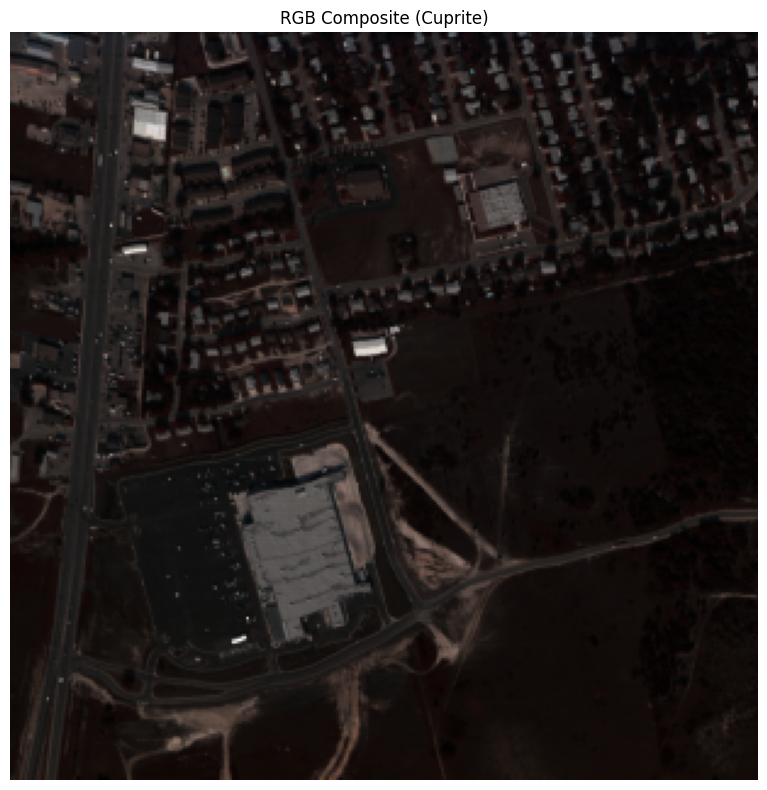


Data Preview:
First 5 pixels from first band:
[0.14342105 0.15263158 0.15657895 0.14736842 0.14736842]
First 5 values from first endmember:
[0.097 0.1   0.104 0.1   0.103]


In [ ]:
def main():
    """Example usage of the consolidated processor."""
    # Initialize processor
    processor = HyperspectralProcessor(base_path="../datasets", verbose=True)

    # Process Cuprite dataset (ID=0)
    try:
        img2d, Mp, h, w, num_bands, num_endmembers = processor.preprocess_dataset(dataset_id=4)

        # Print info
        processor.print_dataset_info(img2d, Mp, h, w, num_bands, num_endmembers, dataset_id=4)

        # Create and display RGB composite (requires 3D cube)
        # Reconstruct 3D cube for visualization - CORRECTED
        if w is not None and h is not None:
            # img2d is (bands, pixels), need to reshape to (h, w, bands)
            img_cube = img2d.T.reshape(h, w, num_bands)  # (190, 250, 188) - matches your working code
            processor.display_rgb_composite(img_cube, dataset_id=0)

        # Show data previews
        print("\nData Preview:")
        print("First 5 pixels from first band:")
        print(img2d[0, :5])
        print("First 5 values from first endmember:")
        print(Mp[:5, 0])
    except Exception as e:
        print(f"Error processing dataset: {e}")

if __name__ == "__main__":
    main()